In [1]:
import os
import scipy.io
import numpy as np
from scipy import signal

data_path = "/kaggle/input/control1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250

control_data = []
control_path = os.path.join(data_path, 'Control')

for foldername in os.listdir(control_path):
    subfolder_path = os.path.join(control_path, foldername)
    control_data.append(subfolder_path)

Control30 = []

for control_data_path in control_data:
    n_epochs = 70 
    start_epoch = 1
    end_epoch = 110

    control_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = os.path.join(control_data_path, f"trial{i}.mat")
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]    
        #print(mat_data1.shape)
        # Downsampling
        num_samples_original = mat_data1.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        #print(downsampled_data.shape)
        
        control_arr.append(downsampled_data)
        Control30.append(downsampled_data)

Control30 = np.array(Control30)

print(Control30.shape)

(3300, 60, 1000)


In [2]:
import numpy as np
from scipy.stats import entropy
from scipy import signal

epsilon = 1e-8
alpha_band = (8, 12)
beta_band = (12, 30)
delta_band = (0.5, 4)

num_samples = Control30.shape[0]
num_channels = Control30.shape[1]

features_control = np.zeros((num_samples, num_channels, 4))

for sample_idx in range(num_samples):
    for channel_idx in range(num_channels):
        channel_data = Control30[sample_idx, channel_idx, :]

        freq_spectrum = np.fft.fft(channel_data)
        power_spectrum = np.abs(freq_spectrum) ** 2

        alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
        beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
        delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

        channel_min_value = np.min(channel_data)
        channel_max_value = np.max(channel_data)

        power_spectrum_adjusted = power_spectrum + epsilon
        entropy_values = entropy(power_spectrum_adjusted)

        values = np.array([alpha_power, beta_power, delta_power, entropy_values])
        rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value

        features_control[sample_idx, channel_idx, :] = rescaled_values

print(features_control.shape)


(3300, 60, 4)


In [3]:
import os
import scipy.io
import numpy as np
from scipy import signal
data_path = "/kaggle/input/concussed1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250  

concussed_data = []
concussed_path = os.path.join(data_path, 'Concussed')
for foldername in os.listdir(concussed_path):
    subfolder_path = os.path.join(concussed_path, foldername)
    concussed_data.append(subfolder_path)
    
concussed_data = concussed_data[:30]

Concussed52 = []
for concussed_data_path in concussed_data:
    n_epochs = 70
    start_epoch = 1
    end_epoch = 110
    concussed_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = f"{concussed_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        f0 = 60 
        Q = 30  
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.lfilter(b, a, mat_data1)
        
        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        concussed_arr.append(np.array(downsampled_data))
        
        Concussed52.append(downsampled_data)

Concussed52 = np.array(Concussed52)

print( Concussed52.shape)


(3300, 60, 1000)


In [4]:
import numpy as np
from scipy.stats import entropy
from scipy import signal

epsilon = 1e-8
alpha_band = (8, 12)
beta_band = (12, 30)
delta_band = (0.5, 4)

num_samples = Concussed52.shape[0]
num_channels = Concussed52.shape[1]
features_concussed = np.zeros((num_samples, num_channels, 4))

for sample_idx in range(num_samples):
    for channel_idx in range(num_channels):
        channel_data = Concussed52[sample_idx, channel_idx, :]

        freq_spectrum = np.fft.fft(channel_data)
        power_spectrum = np.abs(freq_spectrum) ** 2

        alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
        beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
        delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

        channel_min_value = np.min(channel_data)
        channel_max_value = np.max(channel_data)

        power_spectrum_adjusted = power_spectrum + epsilon
        entropy_values = entropy(power_spectrum_adjusted)

        values = np.array([alpha_power, beta_power, delta_power, entropy_values])
        rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value

        features_concussed[sample_idx, channel_idx, :] = rescaled_values

print(features_concussed.shape)

(3300, 60, 4)


In [5]:
dataset = np.concatenate((Control30, Concussed52), axis=0)
labels = np.concatenate((np.zeros(Control30.shape[0]), np.ones(Concussed52.shape[0])))

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(Control30, np.zeros(Control30.shape[0]), test_size=0.2, random_state=42)
X_train_concussed, X_test_concussed, y_train_concussed, y_test_concussed = train_test_split(Concussed52, np.ones(Concussed52.shape[0]), test_size=0.2, random_state=42)

X_train_features_control, X_test_features_control, _, _ = train_test_split(features_control, np.zeros(features_control.shape[0]), test_size=0.2, random_state=42)
X_train_features_concussed, X_test_features_concussed, _, _ = train_test_split(features_concussed, np.ones(features_concussed.shape[0]), test_size=0.2, random_state=42)
X_train_eeg = np.concatenate((X_train_control, X_train_concussed))
X_test_eeg = np.concatenate((X_test_control, X_test_concussed))
X_train_features = np.concatenate((X_train_features_control, X_train_features_concussed))
X_test_features = np.concatenate((X_test_features_control, X_test_features_concussed))
y_train = np.concatenate((y_train_control, y_train_concussed))
y_test = np.concatenate((y_test_control, y_test_concussed))

eeg_input = Input(shape=(60, 1000))
conv1 = Conv1D(64, 3, activation='relu')(eeg_input)
maxpool1 = MaxPooling1D(2)(conv1)
flatten1 = Flatten()(maxpool1)
dropout1 = Dropout(0.5)(flatten1)

feature_input = Input(shape=(60, 4))
flatten2 = Flatten()(feature_input)

concatenated = concatenate([dropout1, flatten2])
batchnorm1 = BatchNormalization()(concatenated)

dense1 = Dense(128, activation='relu')(batchnorm1)
dropout2 = Dropout(0.5)(dense1)

output = Dense(1, activation='sigmoid')(dropout2)

model = Model(inputs=[eeg_input, feature_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.5
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit([X_train_eeg, X_train_features], y_train, epochs=100, batch_size=256, validation_data=([X_test_eeg, X_test_features], y_test), callbacks=[lr_callback, early_stopping])
test_loss, test_accuracy = model.evaluate([X_test_eeg, X_test_features], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Epoch 1/100
21/21 [==============================] - 8s 285ms/step - loss: 0.8630 - accuracy: 0.5805 - val_loss: 1.2305 - val_accuracy: 0.5742 - lr: 0.0030
Epoch 2/100
21/21 [==============================] - 5s 231ms/step - loss: 0.6560 - accuracy: 0.6583 - val_loss: 0.7293 - val_accuracy: 0.6220 - lr: 0.0030
Epoch 3/100
21/21 [==============================] - 5s 247ms/step - loss: 0.5904 - accuracy: 0.7076 - val_loss: 0.6816 - val_accuracy: 0.6205 - lr: 0.0030
Epoch 4/100
21/21 [==============================] - 5s 233ms/step - loss: 0.5229 - accuracy: 0.7373 - val_loss: 0.5349 - val_accuracy: 0.7318 - lr: 0.0030
Epoch 5/100
21/21 [==============================] - 5s 227ms/step - loss: 0.5024 - accuracy: 0.7581 - val_loss: 0.5153 - val_accuracy: 0.7561 - lr: 0.0030
Epoch 6/100
21/21 [==============================] - 5s 230ms/step - loss: 0.4614 - accuracy: 0.7754 - val_loss: 0.5626 - val_accuracy: 0.7189 - lr: 0.0030
Epoch 7/100
21/21 [==============================] - 5s 226ms/st

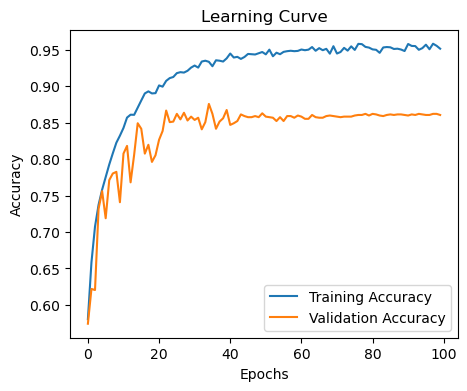

42/42 [==============================] - 1s 12ms/step


Classification Report:
              precision    recall  f1-score   support

     Control       0.81      0.94      0.87       660
   Concussed       0.93      0.78      0.85       660

    accuracy                           0.86      1320
   macro avg       0.87      0.86      0.86      1320
weighted avg       0.87      0.86      0.86      1320



Confusion Matrix:
[[619  41]
 [143 517]]


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
y_pred = model.predict([X_test_eeg, X_test_features])
y_pred_binary = np.round(y_pred).flatten()

#confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

#classification report
target_names = ['Control', 'Concussed']
report = classification_report(y_test, y_pred_binary, target_names=target_names)
print("\n\nClassification Report:")
print(report)
cr = classification_report(y_test, y_pred_binary)

print("\n\nConfusion Matrix:")
print(cm)

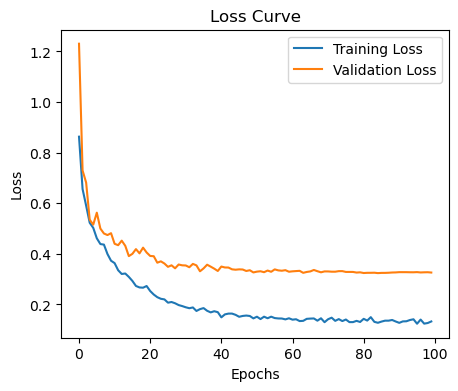

In [9]:
#loss curve
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_pred_binary = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cm, fmt='', annot=labels, cmap='Greens')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values\n')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()



# sample_index = 1

input_sample_eeg = X_test_eeg[sample_index]
input_sample_features = X_test_features[sample_index]
true_label = y_test[sample_index]
input_sample_eeg = np.expand_dims(input_sample_eeg, axis=0)
input_sample_features = np.expand_dims(input_sample_features, axis=0)
prediction = model.predict([input_sample_eeg, input_sample_features])
binary_prediction = 1 if prediction > 0.5 else 0
is_correct = binary_prediction == true_label
print("Input EEG shape:", input_sample_eeg.shape)
print("Input features shape:", input_sample_features.shape)
print("True Label:", true_label)
print("Predicted Label:", binary_prediction)
print("Prediction is Correct:", is_correct)


In [ ]:
TP = 558
FN = 102
FP = 72
TN = 1006

Precision = TP / (TP + FP)
Sensitivity = TP / (TP + FN)
Specificity = TN /(TN + FP)
False_Pos_Rate = FP / (TN + FP)
False_Neg_Rate = FN / (FN + TP)
F1_Score = (2*Precision*Sensitivity) / (Precision + Sensitivity)
Accuracy = (TP+TN) / (TP+FP+TN+FN)

precision = "{:.2f}".format(Precision)
sensitivity = "{:.2f}".format(Sensitivity)
specificity = "{:.2f}".format(Specificity)
false_pos_rate = "{:.2f}".format(False_Pos_Rate)
false_neg_rate = "{:.2f}".format(False_Neg_Rate)
f1_score = "{:.2f}".format(F1_Score)
accuracy = "{:.2f}".format(Accuracy)

print("Precision          :", precision)
print("Sensitivity        :", sensitivity)
print("Specificity        :", specificity)
print("F1-Score           :", f1_score)
print("False Positive Rate:", false_pos_rate)
print("False Negative Rate:", false_neg_rate)
print("Accuraccy          :", accuracy)